In [1]:
# 2 Agents
# Research Agent-create bullet point notes for a topic
# Writer Agent - converting the reasearch notes into Linkedin Post

In [2]:
!pip install langchain langchain_google_genai langgraph

In [3]:
# StateGraph - Shared Memory, context, Intermediate Outputs
import os
os.environ["GOOGLE_API_KEY"]= "api-key-here"

In [4]:
from typing import TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END

In [5]:
class AgentState(TypedDict):
    question: str # Original query from user
    research:str # Output from research agent
    draft: str # output from writer agent


llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash",
                                temperature=0.3)

def reasearch_agent(state: AgentState) -> AgentState:
  question =state["question"]

  prompt= f"""
  You are a Research agent,
  Task: Create a Simple set o bullet point notes that explains the topic in a way
  that beginner can understand.

  Topic/question:
  {question}

  Rules:
  - Use Short, clear bullet points
  - Avoid Technical jargons
  - maximum 8 bullet points"""

  response = llm.invoke(prompt)

  return {**state, "research": response.content} # keep previous state, and research notes


def writer_agent(state:AgentState) -> AgentState:
  research = state["research"]
  question = state["question"]
  prompt = f"""
  You are a writer agent.
  Task: Use the Research notes below to write a short LinkedIn post, that teacches this
  topic in a simple & Engaging Way.

  Topic:
  {question}

  Research Notes:
  {research}

  Rules:
  - Start with a hook (1-2 lines)
  - Then Share 3-5 short lines with value/explanation
  - End with a simple call to action (e.g.'Save this for later' or 'Comment if this resonates with you' )
  - Keep it less than 200 words
  """

  response = llm.invoke(prompt)

  return {**state, "draft": response.content}

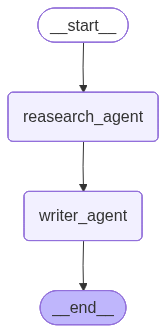

In [6]:
workflow = StateGraph(AgentState)

workflow.add_node("reasearch_agent", reasearch_agent)
workflow.add_node("writer_agent", writer_agent)

workflow.add_edge(START, "reasearch_agent")
workflow.add_edge("reasearch_agent","writer_agent")
workflow.add_edge("writer_agent", END)

# compile the graph
graph = workflow.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [7]:
user_question = "Explain Multi Agent systems and its importance in Enterprise in simple terms"

initial_state: AgentState = {"question":user_question}

final_state = graph.invoke(initial_state)
print("Reasearch Agent Output")
print(final_state["research"])

print("Writer Agent Output")
print(final_state["draft"])

Reasearch Agent Output
Here's a simple explanation of Multi-Agent Systems for beginners:

*   **Smart Helpers:** Think of "agents" as small, smart computer programs that can make decisions and act on their own.
*   **Teamwork:** A "Multi-Agent System" is simply many of these smart helpers working together.
*   **Talking & Sharing:** They communicate with each other, share information, and divide up tasks.
*   **Bigger Problems:** This allows them to solve problems that are too big or complex for one helper alone.
*   **For Businesses:** In a company, these systems can automate tricky jobs, like managing orders or customer service.
*   **Better Decisions:** They help different parts of the business make smarter, faster choices based on real-time info.
*   **Smooth Operations:** They can coordinate many different systems or processes to run smoothly and without human intervention.
*   **More Efficient:** This makes the entire company more efficient, saves time, and helps reduce mistakes.

In [9]:
question = "What is Agentic AI ?"

example =f"""
  You are a Research agent,
  Task: Create a Simple set o bullet point notes that explains the topic in a way
  that beginner can understand.

  Topic/question:
  {question}

  Rules:
  - Use Short, clear bullet points
  - Avoid Technical jargons
  - maximum 8 bullet points"""


print(example)


  You are a Research agent, 
  Task: Create a Simple set o bullet point notes that explains the topic in a way 
  that beginner can understand.

  Topic/question:
  What is Agentic AI ?

  Rules:
  - Use Short, clear bullet points
  - Avoid Technical jargons
  - maximum 8 bullet points


In [10]:
question = "What is Agentic AI ?"

example ="""
  You are a Research agent,
  Task: Create a Simple set o bullet point notes that explains the topic in a way
  that beginner can understand.

  Topic/question:
  {}

  Rules:
  - Use Short, clear bullet points
  - Avoid Technical jargons
  - maximum 8 bullet points""".format(question)


print(example)


  You are a Research agent, 
  Task: Create a Simple set o bullet point notes that explains the topic in a way 
  that beginner can understand.

  Topic/question:
  What is Agentic AI ?

  Rules:
  - Use Short, clear bullet points
  - Avoid Technical jargons
  - maximum 8 bullet points


In [12]:
from langchain_core.prompts import ChatPromptTemplate
question = "What is Agentic AI ?"

prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
         "You are in expert assistant."),
         ("user",
          """You are a Research agent,
          Task: Create a Simple set o bullet point notes that explains the topic in a way
          that beginner can understand.

          Topic/question:
          {question}

          Rules:
          - Use Short, clear bullet points
          - Avoid Technical jargons
          - maximum 8 bullet points"""
          )
    ]
)

variables = {"question" : question}
prompt.invoke(variables)

ChatPromptValue(messages=[SystemMessage(content='You are in expert assistant.', additional_kwargs={}, response_metadata={}), HumanMessage(content='You are a Research agent, \n          Task: Create a Simple set o bullet point notes that explains the topic in a way \n          that beginner can understand.\n\n          Topic/question:\n          What is Agentic AI ?\n\n          Rules:\n          - Use Short, clear bullet points\n          - Avoid Technical jargons\n          - maximum 8 bullet points', additional_kwargs={}, response_metadata={})])

In [13]:
dict1 = {"a":1, "b":2}

dict2 = {dict1, "c":3}
print(dict2)

SyntaxError: invalid syntax (ipython-input-1125900611.py, line 3)

In [15]:
dict1 = {"a":1, "b":2}
dict2 = {**dict1, "c":3} # unpack the dict1 in backend automatically
print(dict2)

{'a': 1, 'b': 2, 'c': 3}


In [16]:
question: str = 100 #Python does not enforce the data type runtime

# Supervisor Worker Pattern

In [17]:
#Supervisor -breakdown the big request into smaller tasks
# Three workers - writer, researcher, analyst do the tasks
# Supervisor then combines their work into final answer

In [3]:
# User request --> Supervisor
# Supervisor --> Create Tasks and assigns Workers
# Workers --> Execute Tasks and adds the results
# Supervisor --> Aggregate everything into final_results

In [19]:
import os
import json
from typing import List, Dict,TypedDict
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate

In [20]:
os.environ["GOOGLE_API_KEY"]= "api-key"

In [23]:
#Task + State

class Task(TypedDict):
  task_id: int
  description: str #what needs to be done
  assigned_to: str # writer, researcher, analyst
  result: str # output generated by worker

class State(TypedDict):
    user_request: str # Original query from user
    tasks: List[Task]
    final_result: str


class SupervisorAgent:
  def __init__(self):
    self.llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash",
                                temperature=0.3)

  def plan(self, user_request: str) -> List[Task]:
    """Break down the user request and assign the tasks to workers"""
    prompt = ChatPromptTemplate.from_messages([
        ("system","""You are a supervisor agent, that breaksdown requests into tasks
        and assign them to specialized workers (Writers, Reasearchers, Analyst)"""),
        ("human","""Request:{user_request}
        Create 2-3 tasks and assign each to a worker
        - Writer: for content creation
        - Researcher: for Information Gathering
        - Analyst: for Data Analysis

        Return JSON:
        {{
          "tasks": [
            {{"task_id": 1, "description": "task description", "assigned_to": "writer"}},
            {{ "task_id": 2, "description": "task description", "assigned_to": "researcher"}
            ]
        }}
        """
        )
    ])
    chain = prompt | self.llm
    response = chain.invoke({"user_request": user_request})
    content =response.content
    print("Output from Supervisor Agent")
    print(content)
    return json.loads(content)["tasks"]

    def aggregate(self, user_request:str, tasks: List[Task]) -> str:
      "Combine the worker results into final output"
      result_text = "\n\n".join([f"Task {t.task_id} ({t.assigned_to}: {t.result})" for t in tasks if t.result])

      prompt = ChatPromptTemplate.from_messages([
          ("system","You are a supervisor, combine the worker results into a final response"),
          ("human","""Original Request: {user_request}
          Worker Results:
          {results}

          Combine these into a complete coherent response:
          """)]
      )
      chain = prompt | self.llm
      response = chain.invoke({"user_request": user_request, "results": results_text})
      return response.content


In [24]:
class WorkerAgent:

  def __init__(self, worker_type:str):
    self.worker_type = worker_type
    self.llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash",
                                temperature=0.3)

  def execute(self, user_request:str, task: Task) -> str:
    worker_prompt = {
        "Writer": "You are a writer, create clear and engaging content",
        "Researcher": "You are a Researcher, Gather and summarize information.",
        "Analyst": "You are an analyst, analyze the data and provide insights"
    }

    prompt = ChatPromptTemplate.from_messages([
        ("system",worker_prompt.get(self.worker_type, "You are a worker. Complete the task")),
        ("human","""Original Request: {user_request}

         Your Task: {task_description}

         Complete this task as a {worker_type}:""")])
    chain = prompt| self.llm

    response = chain.invoke({"user_request": user_request,
                             "task_description":task.description,
                             "worker_type": self.worker_type})
    return response.content

In [25]:
def create_workflow():

  supervisor = SupervisorAgent()

  workers = {
      "Writer":WorkerAgent("Writer"),
      "Researcher":WorkerAgent("Researcher"),
      "Analyst":WorkerAgent("Analyst")
  }

In [3]:
# node 1

def supervisor_plan_node(state:dict) -> dict:
  print("Supervisor Plan Node")
  state_obj = State(**state)
  tasks = supervisor.plan(state_obj.user_request)
  print("Generated tasks", tasks)

# node 2

def worker_execute_node(state:dict) -> dict:
  print("Worker Execution  Node")
  state_obj = State(**state)
  tasks = [Task(**t) for t in state_obj.tasks ]

  for task in tasks:
    if task.assigned_to in workers:
      print(f"Worker assigned is {task.assigned_to}")
      worker =workers[task.assigned_to]
      task.result = worker.execute(state_obj.user_request, task)
      print("Task completed")
  return {"tasks": tasks}

In [ ]:
# node 3

def supervisor_agg_node(state:dict) -> dict:
  print("Worker Execution  Node")
  state_obj = State(**state)
  tasks = [Task(**t) for t in state_obj.tasks ]

  for task in tasks:
    if task.assigned_to in workers:
      print(f"Worker assigned is {task.assigned_to}")
      worker =workers[task.assigned_to]
      task.result = worker.execute(state_obj.user_request, task)
      print("Task completed")
  return {"tasks": tasks}